In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

from utils import *

In [2]:
missingness = Missingness()
train, test = load_mnist()

In [7]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()

    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    for nsig in [1, 2]:
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs))


def plot_gmm_imputation(original, corrupted, imputed):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    cmap = plt.get_cmap("grey")
    cmap.set_bad(color="red")

    ax[0].imshow(original.squeeze().cpu(), cmap=cmap)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(corrupted.squeeze().cpu(), cmap=cmap)
    ax[1].set_title("Corrupted")
    ax[1].axis("off")

    ax[2].imshow(imputed.squeeze().cpu(), cmap=cmap)
    ax[2].set_title("GMM Imputed")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()


def plot():
    global mean

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(image, cmap='gray_r', origin='upper')

    ax[1].imshow(image, cmap='gray_r', origin='upper', alpha=0.3)
    ax[1].scatter(X_train[:, 0], X_train[:, 1], s=10, c='black')

    colors = ['red', 'blue', 'green', 'orange']
    for i in range(n_components):
        mean = gmm.means_[i]
        cov = gmm.covariances_[i]
        draw_ellipse(mean, cov, ax=ax[1], edgecolor=colors[i % len(colors)], fill=False, linewidth=2,
                     label=f'Component {i + 1}')

        ax[1].plot(mean[0], mean[1], 'x', color=colors[i % len(colors)], markersize=10)
    plt.tight_layout()
    plt.show()

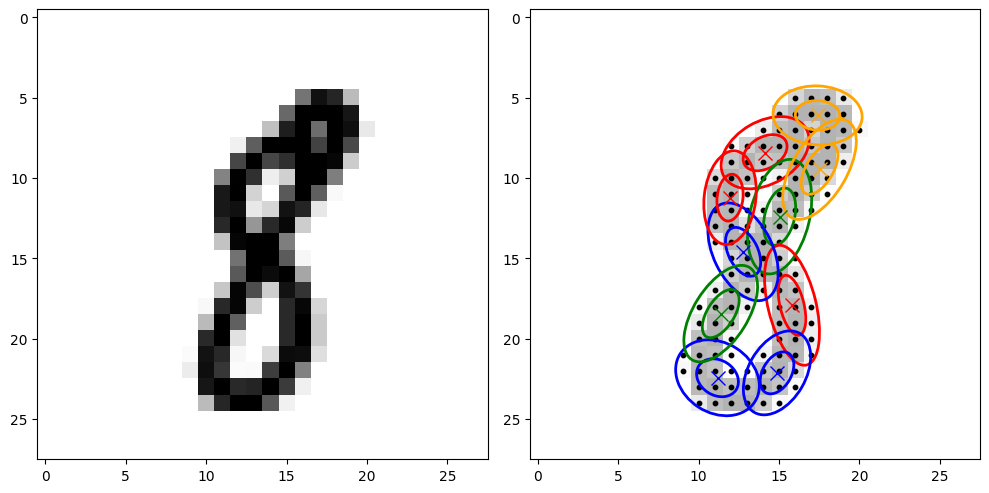

In [8]:
image, label = train[300]
image = image.squeeze()

y_coords, x_coords = np.where(image > 0)
X_train = np.column_stack([x_coords, y_coords])

n_components = 10
gmm = GaussianMixture(n_components=n_components, covariance_type='full')
gmm.fit(X_train)

plot()

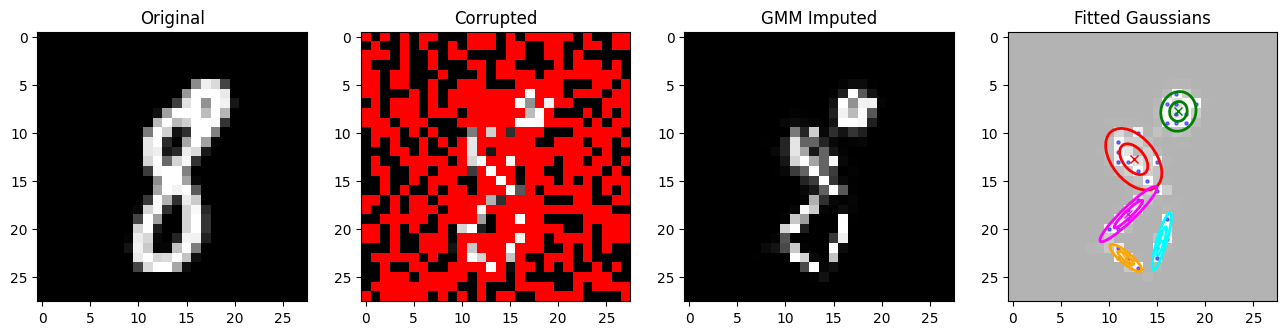

In [11]:
true_image, label = train[111]
true_image = image.squeeze()

corrupted_img, mask = missingness.mcar(true_image, missing_rate=0.6)

imputer = GMMImageImputer(n_components=5)
imputed_tensor = imputer.impute(corrupted_img.unsqueeze(0))

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
cmap = plt.get_cmap('grey')
cmap.set_bad(color='red')

ax[0].imshow(true_image, cmap=cmap)
ax[0].set_title("Original")

ax[1].imshow(corrupted_img, cmap=cmap)
ax[1].set_title("Corrupted")
ax[2].imshow(imputed_tensor.squeeze(), cmap='gray')
ax[2].set_title("GMM Imputed")
ax[3].imshow(imputed_tensor.squeeze(), cmap='gray', alpha=0.3)

valid_mask = ~torch.isnan(corrupted_img)
ink_mask = (corrupted_img > 0.5) & valid_mask
y_train, x_train = np.where(ink_mask.numpy())

ax[3].scatter(x_train, y_train, s=5, c='blue', alpha=0.5, label='Observed Ink')

if imputer.model is not None:
    colors = ['red', 'orange', 'green', 'cyan', 'magenta']
    for i in range(imputer.n_components):
        mean = imputer.model.means_[i]
        cov = imputer.model.covariances_[i]
        draw_ellipse(mean, cov, ax=ax[3], edgecolor=colors[i % len(colors)], fill=False, linewidth=2)
        ax[3].plot(mean[0], mean[1], 'x', color=colors[i % len(colors)])

ax[3].set_title("Fitted Gaussians")

plt.show()

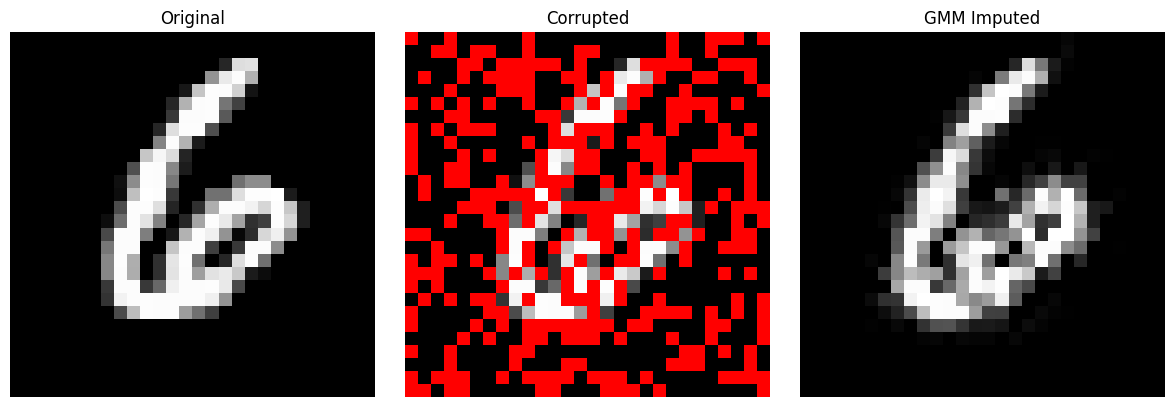

In [12]:
idx = torch.randint(len(train), size=(1,)).item()

true_image, label = train[13]

original_img = true_image.squeeze()
corrupted_img, mask = missingness.mcar(original_img, missing_rate=0.4)

imputer = GMMImageImputer(n_components=5, ink_threshold=0.1)
imputed_img = imputer.impute(corrupted_img.unsqueeze(0))
plot_gmm_imputation(original_img, corrupted_img, imputed_img)